# HW3_대구맛집_클러스터
2022236204 홍정빈

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import json
import requests
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings(action = 'ignore')

In [4]:
# 구별로 json 불러오기

url = 'https://www.daegufood.go.kr/kor/api/tasty.html?mode=json&addr='
url_jung = url + '%EC%A4%91%EA%B5%AC'
url_dong = url + '%EB%8F%99%EA%B5%AC'
url_seo = url + '%EC%84%9C%EA%B5%AC'
url_nam = url + '%EB%82%A8%EA%B5%AC'
url_buk = url + '%EB%B6%81%EA%B5%AC'
url_su = url + '%EC%88%98%EC%84%B1%EA%B5%AC'
url_dal = url + '%EB%8B%AC%EC%84%9C%EA%B5%AC'
url_daln = url + '%EB%8B%AC%EC%84%B1%EA%B5%B0'

r_jung = requests.get(url_jung)
r_dong = requests.get(url_dong)
r_seo = requests.get(url_seo)
r_nam = requests.get(url_nam)
r_buk = requests.get(url_buk)
r_su = requests.get(url_su)
r_dal = requests.get(url_dal)
r_daln = requests.get(url_daln)

json_jung = r_jung.json(strict=False)
json_dong = r_dong.json(strict=False)
json_seo = r_seo.json(strict=False)
json_nam = r_nam.json(strict=False)
json_buk = r_buk.json(strict=False)
json_su = r_su.json(strict=False)
json_dal = r_dal.json(strict=False)
json_daln = r_daln.json(strict=False)

dg_mat = [json_jung, json_dong, json_seo, json_nam, json_buk, json_su, json_dal, json_daln]

In [5]:
dg_list=[]
for i in range (len(dg_mat)) :
    for j in range (len(dg_mat[i]['data'])) :
        dg_list.append((dg_mat[i]['data'][j]['BZ_NM'], dg_mat[i]['data'][j]['GNG_CS']))

adr = pd.DataFrame(dg_list, columns=['name', 'address'])

adr.head()

,name,address
0,송림식당,대구광역시 중구 삼덕동2가 219-1
1,빈플러스 테이스팅 스푼(TASTING SPOON),대구광역시 중구 삼덕동1가 21-10
2,박석규 중앙떡볶이,대구광역시 중구 동성로2가 70-1
3,가스트로락,대구광역시 중구 대봉동 31-67
4,차이,대구광역시 중구 삼덕동1가 14-3


In [6]:
status_success = 0
adr_json = []

for i in tqdm_notebook(range(len(adr))) :   
    q = adr['address'][i]
    api = f'https://api.vworld.kr/req/address?service=address&request=getcoord&version=2.0&crs=epsg:4326&address={q}&refine=true&simple=false&format=json&type=parcel&key=52C3080F-5F83-335E-B72D-6E5156073F68'
    #headers={'User-Agent':'Mozilla/5.0(Windows NT 10.0; Win64; x64) AppleWebKit/537.36(KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'}
    req = requests.get(api) #, headers=headers

    if req.status_code==200 : status_success+=1 
    

    adr_json.append(req.json())
       
print('925 나오면 req 전부 양호 :', status_success)
        
        

  0%|          | 0/925 [00:00<?, ?it/s]

925 나오면 req 전부 양호 : 925


In [7]:
adr_json[0]

{'response': {'service': {'name': 'address',
   'version': '2.0',
   'operation': 'getcoord',
   'time': '31(ms)'},
  'status': 'OK',
  'input': {'type': 'parcel', 'address': '대구광역시 중구 삼덕동2가 219-1'},
  'refined': {'text': '대구광역시 중구 삼덕동2가 219-1',
   'structure': {'level0': '대한민국',
    'level1': '대구광역시',
    'level2': '중구',
    'level3': '',
    'level4L': '삼덕동2가',
    'level4LC': '2711010600',
    'level4A': '삼덕동',
    'level4AC': '2711054500',
    'level5': '219-1',
    'detail': ''}},
  'result': {'crs': 'EPSG:4326',
   'point': {'x': '128.603541305001', 'y': '35.864931923605'}}}}

In [8]:
# 데이터를 확인하던 중 status가 'NOT_FOUND'인 데이터들이 있는 것을 찾았다.
adr_json[900]

{'response': {'service': {'name': 'address',
   'version': '2.0',
   'operation': 'getcoord',
   'time': '21(ms)'},
  'status': 'NOT_FOUND',
  'record': {'total': '0', 'current': '0'},
  'page': {'total': '1', 'current': '1', 'size': '10'}}}

In [9]:
# 확인해보니 주소가 이런식으로 들어있어서 주소변환이 불가능 한 것이었다.
# 이런걸 일일이 수정해줄 수 없으니 그냥 제거하도록 한다...
adr.loc[900]

name                       가창우록리먹거리마을
address    대구광역시 달성군 가창면 우록리 / 삼산리 일대
Name: 900, dtype: object

In [10]:
# status가 OK인 것만 가져온다.
all_xy=[]

for i in range(len(adr_json)) :
    if adr_json[i]['response']['status'] == 'OK' :
        all_xy.append((adr_json[i]['response']['result']['point']['x'],
                       adr_json[i]['response']['result']['point']['y']))

In [11]:
print(len(all_xy), 925-len(all_xy))
# 925개 주소 중 57개가 문제가 있어 제거했고 데이터는 868개가 되었다.

868 57


In [12]:
# 구별로 따로 담아준다.
jung_xy=[]
dong_xy=[]
seo_xy=[]
nam_xy=[]
buk_xy=[]
su_xy=[]
dal_xy=[]
daln_xy=[]

for i in range(len(adr_json)) :
    if adr_json[i]['response']['status'] == 'OK' :
        if adr_json[i]['response']['refined']['structure']['level2'] == '중구' :
            jung_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))
        elif adr_json[i]['response']['refined']['structure']['level2'] == '동구' :
            dong_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))    
        elif adr_json[i]['response']['refined']['structure']['level2'] == '서구' :
            seo_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))   
        elif adr_json[i]['response']['refined']['structure']['level2'] == '남구' :
            nam_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))   
        elif adr_json[i]['response']['refined']['structure']['level2'] == '북구' :
            buk_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))
        elif adr_json[i]['response']['refined']['structure']['level2'] == '수성구' :
            su_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))   
        elif adr_json[i]['response']['refined']['structure']['level2'] == '달서구' :
            dal_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))   
        elif adr_json[i]['response']['refined']['structure']['level2'] == '달성군' :
            daln_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))   

In [13]:
# 리스트 -> 데이터프레임
df_jung_xy = pd.DataFrame(jung_xy, columns=['x_longitude', 'y_latitude'])
df_dong_xy = pd.DataFrame(dong_xy, columns=['x_longitude', 'y_latitude'])
df_seo_xy = pd.DataFrame(seo_xy, columns=['x_longitude', 'y_latitude'])
df_nam_xy = pd.DataFrame(nam_xy, columns=['x_longitude', 'y_latitude'])
df_buk_xy = pd.DataFrame(buk_xy, columns=['x_longitude', 'y_latitude'])
df_su_xy = pd.DataFrame(su_xy, columns=['x_longitude', 'y_latitude'])
df_dal_xy = pd.DataFrame(dal_xy, columns=['x_longitude', 'y_latitude'])
df_daln_xy = pd.DataFrame(daln_xy, columns=['x_longitude', 'y_latitude'])

# object형 -> float형
df_jung_xy = df_jung_xy.astype(float)
df_dong_xy = df_dong_xy.astype(float)
df_seo_xy = df_seo_xy.astype(float) 
df_nam_xy = df_nam_xy.astype(float) 
df_buk_xy = df_buk_xy.astype(float) 
df_su_xy = df_su_xy.astype(float)
df_dal_xy = df_dal_xy.astype(float) 
df_daln_xy = df_daln_xy.astype(float)

In [15]:
# 지오코딩 API가 안 불러와질 때를 대비해서 미리 저장해둔 csv 파일을 불러온다.
'''
df_jung_xy = pd.read_csv('중구.csv')
df_dong_xy = pd.read_csv('동구.csv')
df_seo_xy = pd.read_csv('서구.csv') 
df_nam_xy = pd.read_csv('남구.csv') 
df_buk_xy = pd.read_csv('북구.csv') 
df_su_xy = pd.read_csv('수성구.csv')
df_dal_xy = pd.read_csv('달서구.csv') 
df_daln_xy = pd.read_csv('달성군.csv')
'''

'''
변수 복붙용
df_jung
df_dong
df_seo
df_nam
df_buk
df_su
df_dal
df_daln
'''

'\n변수 복붙용\ndf_jung\ndf_dong\ndf_seo\ndf_nam\ndf_buk\ndf_su\ndf_dal\ndf_daln\n'

In [16]:
# 각 점들이 centers들과 얼마나 떨어져 있는지 각각 거리 비교할 때 사용
# 거리 '측정'이 아닌 '비교'라서 루트를 씌우든 안 씌우든 비교하는데에는 상관이 없기 때문에 굳이 루트를 씌울 필요는 없다.
# c: centers(x,y),  o: others(x,y)
def distance(c, o):
    return sum((c - o) ** 2)/len(c)


def group_center(g):
    g = np.array(g)
    return g.mean(axis=0)


def cluster(data, k, seed=2022, iter_num=25):
    logs = []
    np.random.seed(seed)
    centers = data[np.random.choice(len(data), size=k, replace=False)]
    for it in range(iter_num):
        group = {}
        for i in range(k):
            group[i] = []
        # find nearest center
        for row in data:
            temp = []
            for i in range(k):
                temp.append(distance(centers[i], row))
            group[np.argmin(temp)].append(row.tolist())

        # plot data store
        for i in range(k):
            group_temp = np.array(group[i])
            group_temp = np.c_[group_temp, np.full(len(group_temp), i)]
            if i == 0:
                grouped = group_temp
            else:
                grouped = np.append(grouped, group_temp, axis = 0)

        # update center
        centers_new = []
        for i in range(k):
            centers_new.append(group_center(group[i]).tolist())
        centers_new = np.array(centers_new)
        # if updated center == center, break

        if np.sum(centers - centers_new) == 0:
            break
        else:
            centers = centers_new
            logs.append(grouped)
    return grouped, logs, it  



In [17]:
data = np.array(df_jung_xy)
k = 10
grouped, logs, it = cluster(data, k)
print(f'iter num:{it}') # 반복횟수

iter num:13


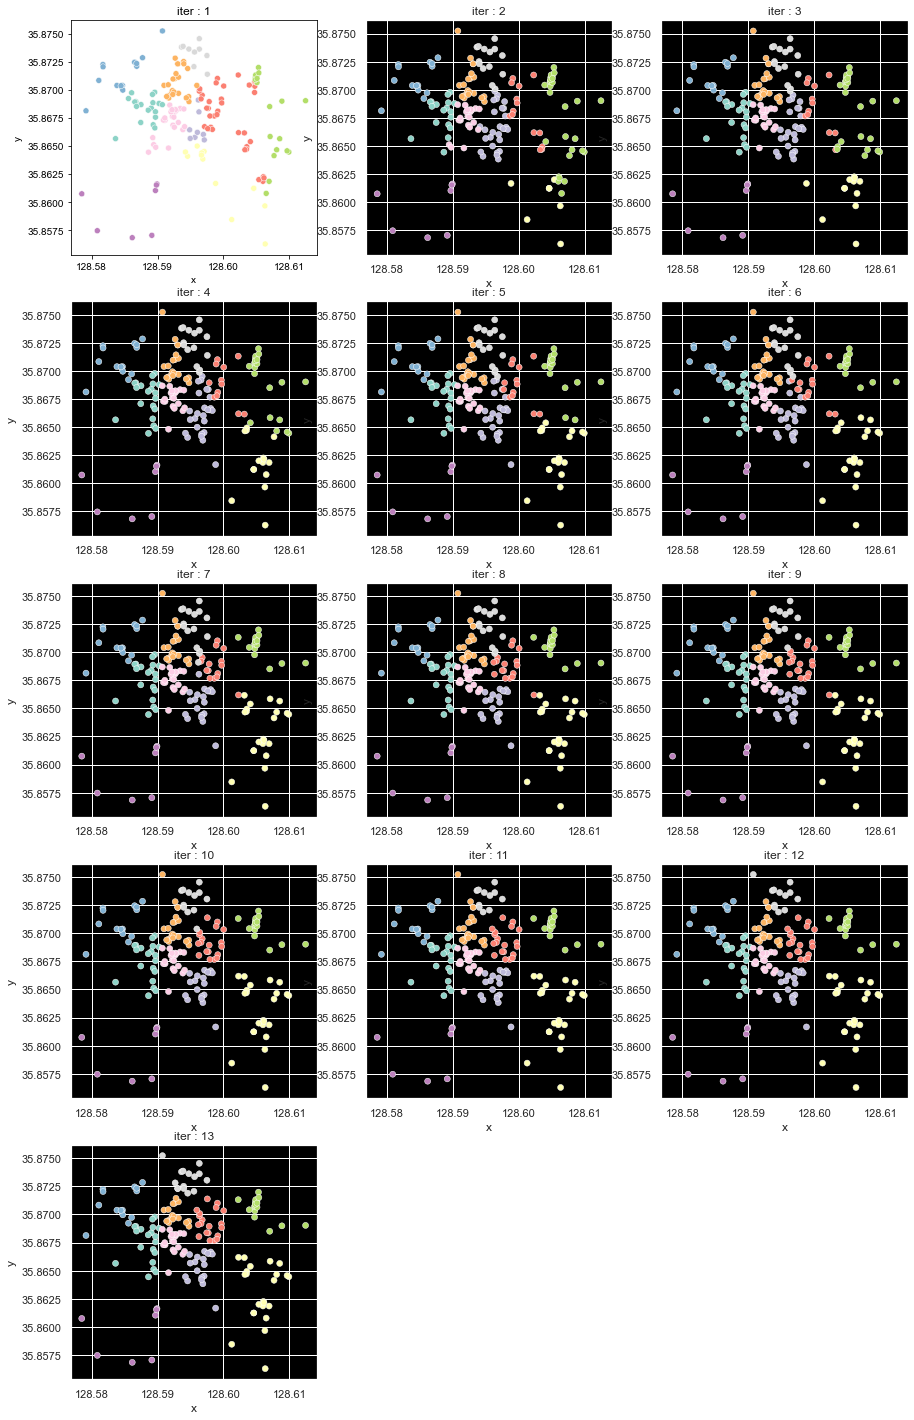

In [18]:
# 중구 클러스터링 시각화
plt.figure(figsize=(15,(it//3+1)*5)) # figsize 중 세로 길이는 도표수에 비례해서 정한다.
for i in range(it):
    plt.subplot(it//3+1, 3, i+1)  # row, col, index
    df = pd.DataFrame(logs[i])
    df.columns = ['x', 'y', 'group']
    sns.set(rc={'axes.facecolor':'black'}) # 배경색 변경. 이유는 모르겠는데 1회 늦게 적용된다.
    sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'group', palette='Set3').set_title(f'iter : {i+1}')
    plt.legend([],[], frameon=False) # 범례를 비워서 안 보이게 함. # 아예 remove하는 방법도 있는데 여기서는 안 됨

중구를 k=10으로 클러스터링 하면 13번의 반복을 거쳐야 한다.

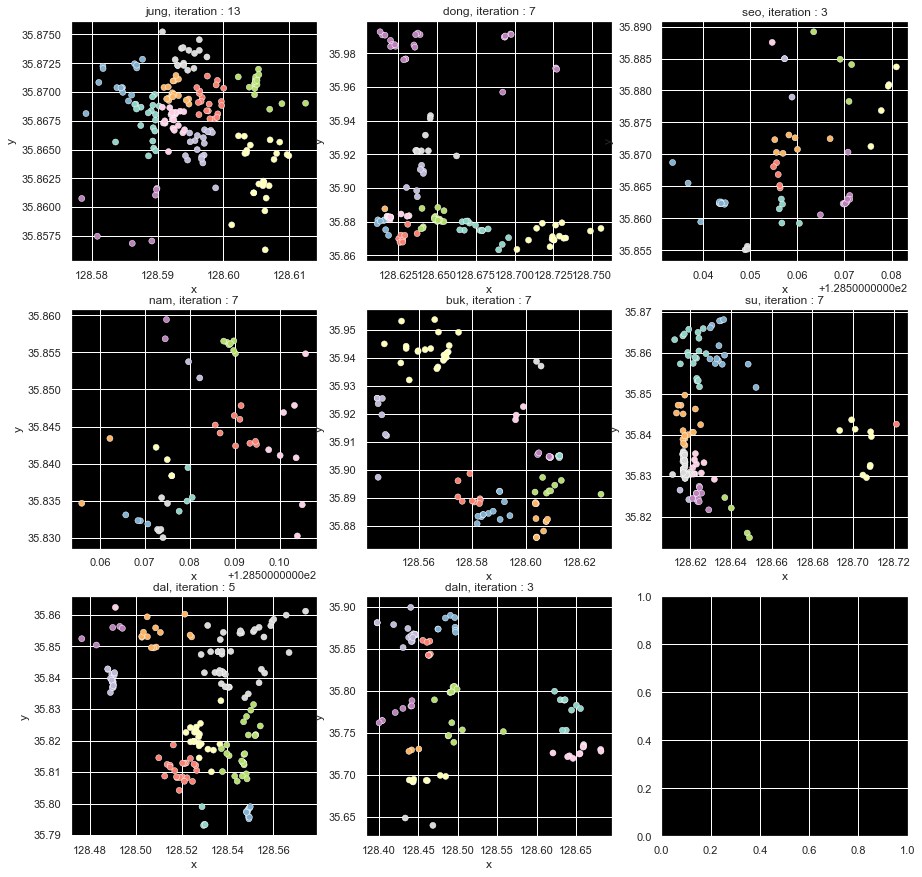

In [19]:
# 모든 구 시각화하기
# 반복문을 써서 코드를 줄이고 싶었지만 이상하게 잘 안 먹혀서 그냥 적었다ㅠㅠ
k=10

figure, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3)
figure.set_size_inches(15,15)

data1 = np.array(df_jung_xy)
grouped, logs, it = cluster(data1, k)
df1 = pd.DataFrame(logs[it-1])
df1.columns = ['x', 'y', 'group']
sns.scatterplot(data = df1, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax1, legend = False).set_title(f'jung, iteration : {it}')

data2 = np.array(df_dong_xy)
grouped, logs, it = cluster(data2, k)
df2 = pd.DataFrame(logs[it-1])
df2.columns = ['x', 'y', 'group']
sns.scatterplot(data = df2, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax2, legend = False).set_title(f'dong, iteration : {it}')

data3 = np.array(df_seo_xy)
grouped, logs, it = cluster(data3, k)
df3 = pd.DataFrame(logs[it-1])
df3.columns = ['x', 'y', 'group']
sns.scatterplot(data = df3, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax3, legend = False).set_title(f'seo, iteration : {it}')

data4 = np.array(df_nam_xy)
grouped, logs, it = cluster(data4, k)
df4 = pd.DataFrame(logs[it-1])
df4.columns = ['x', 'y', 'group']
sns.scatterplot(data = df4, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax4, legend = False).set_title(f'nam, iteration : {it}')

data5 = np.array(df_buk_xy)
grouped, logs, it = cluster(data5, k)
df5 = pd.DataFrame(logs[it-1])
df5.columns = ['x', 'y', 'group']
sns.scatterplot(data = df5, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax5, legend = False).set_title(f'buk, iteration : {it}')

data6 = np.array(df_su_xy)
grouped, logs, it = cluster(data6, k)
df6 = pd.DataFrame(logs[it-1])
df6.columns = ['x', 'y', 'group']
sns.scatterplot(data = df6, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax6, legend = False).set_title(f'su, iteration : {it}')

data7 = np.array(df_dal_xy)
grouped, logs, it = cluster(data7, k)
df7 = pd.DataFrame(logs[it-1])
df7.columns = ['x', 'y', 'group']
sns.scatterplot(data = df7, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax7, legend = False).set_title(f'dal, iteration : {it}')

data8 = np.array(df_daln_xy)
grouped, logs, it = cluster(data8, k)
df8 = pd.DataFrame(logs[it-1])
df8.columns = ['x', 'y', 'group']
sns.scatterplot(data = df8, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax8, legend = False).set_title(f'daln, iteration : {it}')

plt.show()

In [20]:
df_jung = pd.DataFrame(df1['group'].value_counts().sort_index())
df_dong = pd.DataFrame(df2['group'].value_counts().sort_index())
df_seo = pd.DataFrame(df3['group'].value_counts().sort_index())
df_nam = pd.DataFrame(df4['group'].value_counts().sort_index())
df_buk = pd.DataFrame(df5['group'].value_counts().sort_index())
df_su = pd.DataFrame(df6['group'].value_counts().sort_index())
df_dal = pd.DataFrame(df7['group'].value_counts().sort_index())
df_daln = pd.DataFrame(df8['group'].value_counts().sort_index())

## 과제 1-1
좌표로 변환된 대구맛집들에 대해 K=10인 경우 각 행정구(중구, 남구, 달성군 등등) 별로 10개 k-mean cluster의 비율은 어떠한가?

 - 클러스터 x 행정구 형태의 표를 만들고 클러스터의 숫자를 채운뒤 해당 표의 각 행과 열의 합계 항목을 통해 답변하라.
  - 단, sklearn 등 계산 library 사용은 금지한다. (numpy, panda 등은 이용 가능하다.)

In [21]:
df_cluster = pd.concat([df_jung,df_dong,df_seo,df_nam,df_buk,df_su,df_dal,df_daln],axis=1)

df_cluster

,group,group,group,group,group,group,group,group
0.0,20,14,5,4,5,19,4,10
1.0,23,16,5,4,23,9,22,8
2.0,19,7,3,2,8,2,18,17
3.0,20,8,5,9,9,1,23,7
4.0,15,7,11,4,12,14,11,8
5.0,17,1,7,2,11,16,13,3
6.0,17,16,4,7,8,4,27,16
7.0,20,25,1,8,3,10,1,11
8.0,15,10,3,6,2,30,42,2
9.0,7,26,10,2,10,11,5,8


In [22]:
df_cluster.columns = ['중구','동구','서구','남구','북구','수성구','달서구','달성군']
df_cluster.set_index([['c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10']], inplace=True)

df_cluster

,중구,동구,서구,남구,북구,수성구,달서구,달성군
c01,20,14,5,4,5,19,4,10
c02,23,16,5,4,23,9,22,8
c03,19,7,3,2,8,2,18,17
c04,20,8,5,9,9,1,23,7
c05,15,7,11,4,12,14,11,8
c06,17,1,7,2,11,16,13,3
c07,17,16,4,7,8,4,27,16
c08,20,25,1,8,3,10,1,11
c09,15,10,3,6,2,30,42,2
c10,7,26,10,2,10,11,5,8


In [23]:
isum = pd.DataFrame(df_cluster.sum(axis=1), columns=['합계']) # 행(인덱스) 합계
df_cluster = pd.concat([df_cluster, isum], axis=1)

df_cluster

,중구,동구,서구,남구,북구,수성구,달서구,달성군,합계
c01,20,14,5,4,5,19,4,10,81
c02,23,16,5,4,23,9,22,8,110
c03,19,7,3,2,8,2,18,17,76
c04,20,8,5,9,9,1,23,7,82
c05,15,7,11,4,12,14,11,8,82
c06,17,1,7,2,11,16,13,3,70
c07,17,16,4,7,8,4,27,16,99
c08,20,25,1,8,3,10,1,11,79
c09,15,10,3,6,2,30,42,2,110
c10,7,26,10,2,10,11,5,8,79


In [24]:
csum = pd.DataFrame(df_cluster.sum(axis=0), columns=['합계']) # 열(컬럼) 합계
csum = csum.transpose() # 컬럼 합계는 행-열의 위치를 바꿔준다.
df_cluster = pd.concat([df_cluster, csum], axis=0)

df_cluster

,중구,동구,서구,남구,북구,수성구,달서구,달성군,합계
c01,20,14,5,4,5,19,4,10,81
c02,23,16,5,4,23,9,22,8,110
c03,19,7,3,2,8,2,18,17,76
c04,20,8,5,9,9,1,23,7,82
c05,15,7,11,4,12,14,11,8,82
c06,17,1,7,2,11,16,13,3,70
c07,17,16,4,7,8,4,27,16,99
c08,20,25,1,8,3,10,1,11,79
c09,15,10,3,6,2,30,42,2,110
c10,7,26,10,2,10,11,5,8,79


## 과제 1-2
- 초기값을 다르게 설정한 경우에 결과는 어떻게 달라지는가? 

### 이번에는 k 초기값을 3으로 설정해보자!<br>
~~최적의 k값을 찾으라고는 안 하셨으니 내 맘대로...~~

In [25]:
'''
함수를 사용해보려 했는데... 이상하게 또 작동을 안 한다ㅠㅠ

def k_means_c(df_gu_xy, k):
    data = np.array(df_gu_xy)
    grouped, logs, it = cluster(data, k)
    df = pd.DataFrame(logs[it-1])
    df.columns = ['x', 'y', 'group']
    df_gu = pd.DataFrame(df['group'].value_counts().sort_index())

어쩔 수 없이 for문 사용
'''


df_gu_xy = [df_jung_xy, df_dong_xy, df_seo_xy, df_nam_xy, df_buk_xy, df_su_xy, df_dal_xy, df_daln_xy]
k = 3
df_gu = []
for i in range(8):
    data = np.array(df_gu_xy[i])
    grouped, logs, it = cluster(data, k)
    df = pd.DataFrame(logs[it-1])
    df.columns = ['x', 'y', 'group']
    a = pd.DataFrame(df['group'].value_counts().sort_index())
    df_gu.append(a)

In [26]:
df_cluster3 = pd.concat([df_gu[0],df_gu[1],df_gu[2],df_gu[3],df_gu[4],df_gu[5],df_gu[6],df_gu[7]],axis=1)

df_cluster3.columns = ['중구','동구','서구','남구','북구','수성구','달서구','달성군']
df_cluster3.set_index([['c01', 'c02', 'c03']], inplace=True)

isum = pd.DataFrame(df_cluster3.sum(axis=1), columns=['합계'])
df_cluster3 = pd.concat([df_cluster3, isum], axis=1)

csum = pd.DataFrame(df_cluster3.sum(axis=0), columns=['합계'])
csum = csum.transpose()
df_cluster3 = pd.concat([df_cluster3, csum], axis=0)

df_cluster3



,중구,동구,서구,남구,북구,수성구,달서구,달성군,합계
c01,47,78,30,5,58,35,81,22,356
c02,40,24,17,16,25,10,51,27,210
c03,86,28,7,27,8,71,34,41,302
합계,173,130,54,48,91,116,166,90,868


---

## 과제 2
클러스터 계산 방식을 Hierarchical clustering 방식으로 변경할 경우, 대구 맛집을 가장 잘 표현하는 클러스터는 몇개인가?(어떤 방식을 통해서 결론을 도출하였는지를 포함하여 논리적 근거를 명확히 밝혀라)

 - 단, sklearn 등 계산 library 사용은 금지한다. (numpy, panda 등은 이용 가능하다.)

In [27]:
data = np.array(df_jung_xy)

dis1 = []
dis2 = []
for i in range(len(data)):
    a = data[i]    
    for j in range(len(data)):
        b = data[j]
        dis1.append(sum((a - b) ** 2)**0.5)
    dis2.append(dis1)
    dis1 = [] # dis1 초기화

In [59]:
dis_df = pd.DataFrame(dis2)
dis_df

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,172
0,0.000000,0.005630,0.008173,0.005936,0.006651,0.012710,0.012613,0.011601,0.016417,0.011873,...,0.003845,0.017103,0.006976,0.018448,0.012215,0.012066,0.019831,0.012068,0.012554,0.006226
1,0.005630,0.000000,0.002613,0.011077,0.001762,0.007180,0.007477,0.006363,0.014232,0.007511,...,0.008778,0.011831,0.001501,0.013113,0.006720,0.006554,0.014405,0.006443,0.006931,0.000671
2,0.008173,0.002613,0.000000,0.013690,0.002825,0.005108,0.006050,0.004902,0.014622,0.006942,...,0.011389,0.010007,0.001204,0.011181,0.004108,0.003941,0.012337,0.003937,0.004411,0.002192
3,0.005936,0.011077,0.013690,0.000000,0.011549,0.017596,0.016943,0.016125,0.017339,0.015494,...,0.002305,0.021382,0.012548,0.022783,0.017798,0.017631,0.024294,0.017402,0.017894,0.011552
4,0.006651,0.001762,0.002825,0.011549,0.000000,0.006119,0.006010,0.004961,0.012544,0.005786,...,0.009256,0.010472,0.002338,0.011804,0.006606,0.006414,0.013180,0.005918,0.006406,0.001251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0.012066,0.006554,0.003941,0.017631,0.006414,0.003669,0.005765,0.004997,0.016012,0.007843,...,0.015329,0.008111,0.005106,0.008943,0.000205,0.000000,0.009721,0.001439,0.001474,0.006098
169,0.019831,0.014405,0.012337,0.024294,0.013180,0.007256,0.007355,0.008256,0.014109,0.009088,...,0.022097,0.002985,0.013442,0.001606,0.009734,0.009721,0.000000,0.008745,0.008405,0.013747
170,0.012068,0.006443,0.003937,0.017402,0.005918,0.002239,0.004333,0.003618,0.014640,0.006482,...,0.015098,0.006871,0.005138,0.007815,0.001595,0.001439,0.008745,0.000000,0.000492,0.005887
171,0.012554,0.006931,0.004411,0.017894,0.006406,0.002272,0.004462,0.003853,0.014847,0.006716,...,0.015590,0.006656,0.005614,0.007538,0.001579,0.001474,0.008405,0.000492,0.000000,0.006378


In [72]:
# 데이터프레임이 대칭이기 때문에 절반은 없애줘야한다. 
# 원래는 좌하향 데이터를 없애려고 했는데 이상하게 loc나 iloc로 좌하향 데이터를 선택하면 대칭되는 우상향 데이터도 동시에 선택된다;;;
# 어쩔 수 없이 iloc를 이용해 우상향 데이터를 없애주기로 했다.
# 이때 값을 NaN으로 바꾸면 나중에 최소값을 찾을 때 NaN을 찾아버려서 일단은 1로 바꿔준다.
for r in range(len(dis_df)):
    dis_df = dis_df.replace(dis_df.iloc[r,r:len(dis_df)], 1)

In [73]:
dis_df

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,172
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,0.005630,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.008173,0.002613,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
3,0.005936,0.011077,0.013690,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
4,0.006651,0.001762,0.002825,0.011549,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0.012066,0.006554,0.003941,0.017631,0.006414,0.003669,0.005765,0.004997,0.016012,0.007843,...,0.015329,0.008111,0.005106,0.008943,0.000205,1.000000,1.000000,1.000000,1.000000,1.0
169,0.019831,0.014405,0.012337,0.024294,0.013180,0.007256,0.007355,0.008256,0.014109,0.009088,...,0.022097,0.002985,0.013442,0.001606,0.009734,0.009721,1.000000,1.000000,1.000000,1.0
170,0.012068,0.006443,0.003937,0.017402,0.005918,0.002239,0.004333,0.003618,0.014640,0.006482,...,0.015098,0.006871,0.005138,0.007815,0.001595,0.001439,0.008745,1.000000,1.000000,1.0
171,0.012554,0.006931,0.004411,0.017894,0.006406,0.002272,0.004462,0.003853,0.014847,0.006716,...,0.015590,0.006656,0.005614,0.007538,0.001579,0.001474,0.008405,0.000492,1.000000,1.0


In [93]:
c_min = dis_df.min(axis=1) # 각 열에서 최소값 찾음
min_of_total = c_min.min() # 각 열의 최소값 중에서도 최소값을 찾음
min_of_total

8.050720583927621e-05

In [116]:
# 최소값을 가진 컬럼 찾기
find_min = dis_df.isin([min_of_total]) # 최소값을 가졌는지 True, False로 반환
find_min_c = find_min.any()            # 컬럼들 중 True가 1개라도 있는 컬럼 반환
list(find_min[find_min_c==True].index) # True가 나온 컬럼 이름 반환

# 134 컬럼

[134]

In [119]:
# 134 컬럼 안에서 최소값을 가진 행 찾기
dis_df.loc[dis_df[134] == min_of_total]

# 136 행
# 최소값은 (136,134) 위치에 있다!

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,172
136,0.00597,0.006894,0.008094,0.011209,0.008649,0.013169,0.014059,0.012907,0.020802,0.014394,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
def distance_H(data):
    dis_H = []
    for i in range(len(data)):
        a = data[i]    
        for j in range(i+1, len(data)):
            b = data[j]
            dis_H.append(sum((a - b) ** 2)**0.5)


def group_center(g):
    g = np.array(g)
    return g.mean(axis=0)


def cluster(data, k, seed=2022, iter_num=25):
    logs = []
    np.random.seed(seed)
    centers = data[np.random.choice(len(data), size=k, replace=False)]
    for it in range(iter_num):
        group = {}
        for i in range(k):
            group[i] = []
        # find nearest center
        for row in data:
            temp = []
            for i in range(k):
                temp.append(distance(centers[i], row))
            group[np.argmin(temp)].append(row.tolist())

        # plot data store
        for i in range(k):
            group_temp = np.array(group[i])
            group_temp = np.c_[group_temp, np.full(len(group_temp), i)]
            if i == 0:
                grouped = group_temp
            else:
                grouped = np.append(grouped, group_temp, axis = 0)

        # update center
        centers_new = []
        for i in range(k):
            centers_new.append(group_center(group[i]).tolist())
        centers_new = np.array(centers_new)
        # if updated center == center, break

        if np.sum(centers - centers_new) == 0:
            break
        else:
            centers = centers_new
            logs.append(grouped)
    return grouped, logs, it 